# Estado de São Paulo - Resultados

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler, moving_average 

## Functions

In [2]:
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

def model_daily(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += deriv_f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += deriv_f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta >= 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 


## Main code

In [29]:
# Increase font-size
plt.rcParams.update({'font.size': 14})

# Import data
data = pd.read_csv("Datasets/campinas.csv")  
city_name = 'Campinas'

scaling_factor = 1
# scaling_factor = max(data.total_confirmed) # não fica tão bom... (curioso)
#scaling_factor = 15

acc_data = data.total_confirmed / scaling_factor
normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()
daily_data = list(data.new_confirmed / scaling_factor)

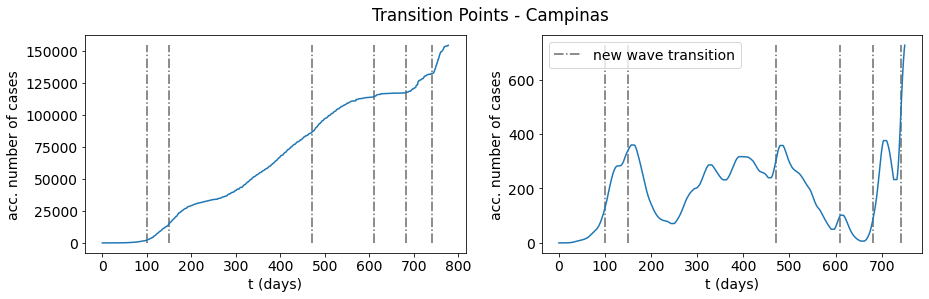

[119, 168, 490, 629, 700, 760]

In [30]:
# Transition Points
if city_name == 'São José dos Campos':
    #x_nw = [147, 287, 382, 669] #(SJC)
    x_nw = [147, 287, 382, 669] #(SJC)
elif city_name == 'São Paulo':
    x_nw = [89, 254, 309, 370, 683] # (SP)
elif city_name == 'Campinas':
    #x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
    x_nw = [100, 149, 471, 610, 681, 741] # Campinas tr 3e-5
else:
    print('Cidade desconhecida!')
    x_nw = [147, 287, 382, 669] 
    
fig, axs = plt.subplots(1, 2, figsize=(15,4))
plt.suptitle(f'Transition Points - {city_name}')
axs[0].vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[0].plot(acc_data)
axs[0].set_xlabel('t (days)')
axs[0].set_ylabel('acc. number of cases')
axs[1].vlines(x_nw, 0, max(filter_data(daily_data)), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[1].plot(filter_data(daily_data))
axs[1].set_xlabel('t (days)')
axs[1].set_ylabel('acc. number of cases')
plt.legend()
plt.savefig(f'ESTADOSP/TP_{city_name}', facecolor='white', dpi=100)
plt.show()

x_nw_novo = []
for i in range(len(x_nw)):
    x_nw_novo.append(x_nw[i] + 14 + 5)
x_nw = x_nw_novo
x_nw

### Predictions (Cumulative + Daily)

========= Wave nr 1 =========
From 0 to  94
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 2397.640942154359
     jac: array([-0.00012207,  0.04507446, -0.03967285,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 124
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([5.11241364e+03, 8.35440371e+01, 1.45918815e+01, 1.00000000e+00])
Step 2
     fun: 1266.257588561161
     jac: array([-1.98364258e-04,  1.46331787e-02,  4.74548340e-03,  9.47508789e+02])
 message: 'Optimization terminated successfully'
    nfev: 276
     nit: 50
    njev: 50
  status: 0
 success: True
       x: array([1.18833653e+04, 1.04664893e+02, 4.09698176e+01, 1.00000000e-01])


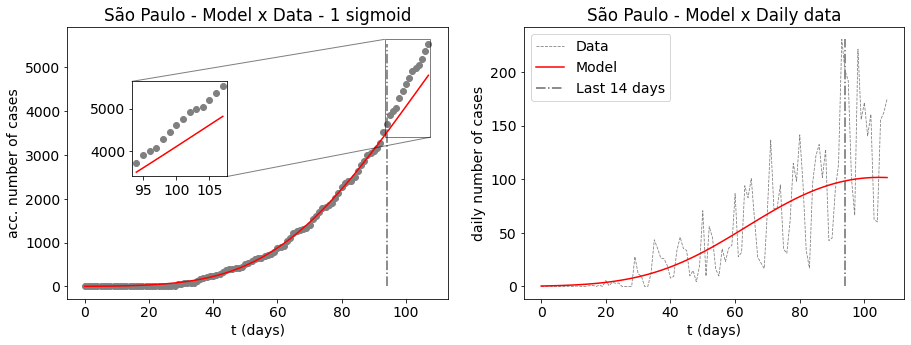

Parameters: [[11883.365347776737, 104.66489331956518, 40.96981758393412, 0.09999999999999999]]
========= Wave nr 2 =========
From 0 to  259
Step 1
     fun: 40860.438004425036
     jac: array([ 0.00146484, -0.10546875, -0.01416016,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 101
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([9.54450445e+03, 1.65193914e+02, 2.48560369e+01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 25018.96243264487
     jac: array([ 0.00195312,  0.0168457 ,  0.0090332 , -0.09936523])
 message: 'Optimization terminated successfully'
    nfev: 126
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([1.04006769e+04, 1.56588616e+02, 4.02044438e+01, 1.66581964e-01])


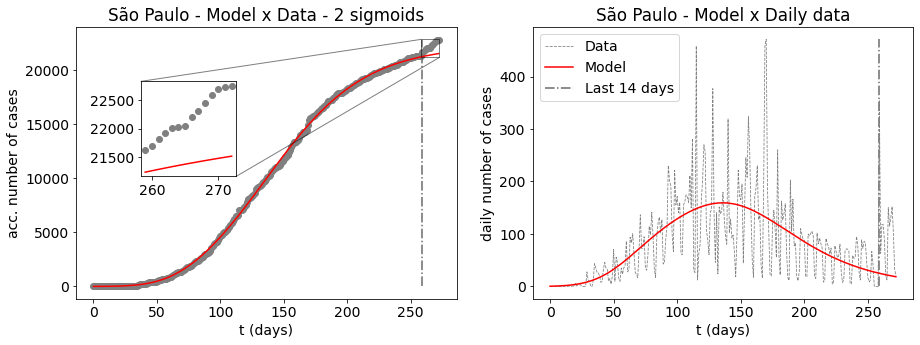

Parameters: [[11883.365347776737, 104.66489331956518, 40.96981758393412, 0.09999999999999999], [10400.676919342488, 156.5886159452999, 40.20444377348169, 0.16658196374460896]]
========= Wave nr 3 =========
From 0 to  314
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 26065.265288177703
     jac: array([-0.0012207 ,  0.01269531, -0.06103516,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 134
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([5.43316848e+03, 2.89062523e+02, 1.26414233e+01, 1.00000000e+00])
Step 2
     fun: 22594.688837780068
     jac: array([ 4.88281250e-04, -5.85937500e-03, -1.07421875e-02,  3.24413721e+03])
 message: 'Optimization terminated successfully'
    nfev: 175
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([7.22615285e+03, 2.89793476e+02, 2.59562723e+01, 1.00000000e-01])


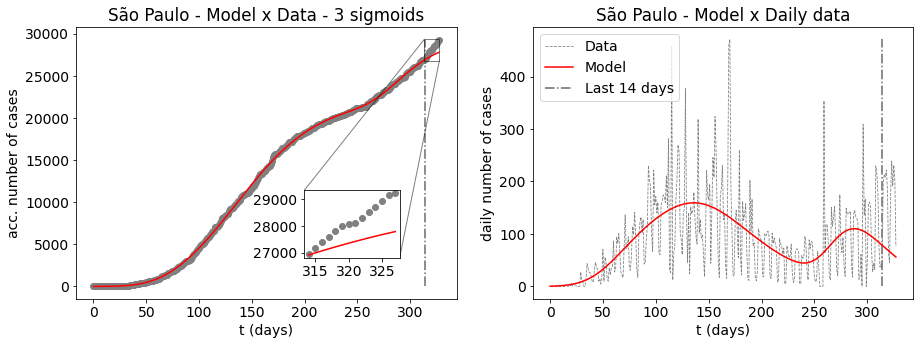

Parameters: [[11883.365347776737, 104.66489331956518, 40.96981758393412, 0.09999999999999999], [10400.676919342488, 156.5886159452999, 40.20444377348169, 0.16658196374460896], [7226.152852127548, 289.7934757019035, 25.956272260908385, 0.09999999999992566]]
========= Wave nr 4 =========
From 0 to  375
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 27957.155056378484
     jac: array([-0.00219727,  0.02856445,  0.00854492,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 147
     nit: 25
    njev: 24
  status: 0
 success: True
       x: array([6.61718445e+03, 3.45013178e+02, 1.21798669e+01, 1.00000000e+00])
Step 2
     fun: 22347.823248695495
     jac: array([ 1.22070312e-03, -2.63671875e-02, -1.70898438e-03,  5.57868994e+03])
 message: 'Optimization terminated successfully'
    nfev: 119
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([7.97995480e+03, 3.42858822e+02, 2.27142149e+01, 1.00000000e-01])


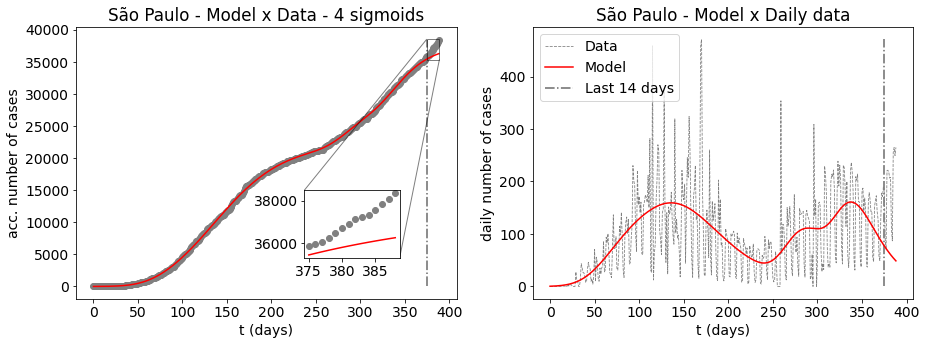

Parameters: [[11883.365347776737, 104.66489331956518, 40.96981758393412, 0.09999999999999999], [10400.676919342488, 156.5886159452999, 40.20444377348169, 0.16658196374460896], [7226.152852127548, 289.7934757019035, 25.956272260908385, 0.09999999999992566], [7979.954798263942, 342.8588217414314, 22.71421494647025, 0.09999999999994148]]
========= Wave nr 5 =========
From 0 to  688
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 472177.6474857921
     jac: array([ 0.01171875, -0.1171875 ,  0.        ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 127
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([2.73369526e+04, 4.55926366e+02, 3.54461547e+01, 1.00000000e+00])
Step 2
     fun: 472177.6474857921
     jac: array([-1.17187500e-02, -1.17187500e-01, -5.07812500e-02,  4.13229801e+05])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([2.73369526e+04, 4.55926366e+02, 3.54461547e+01, 1.00000000e+00])


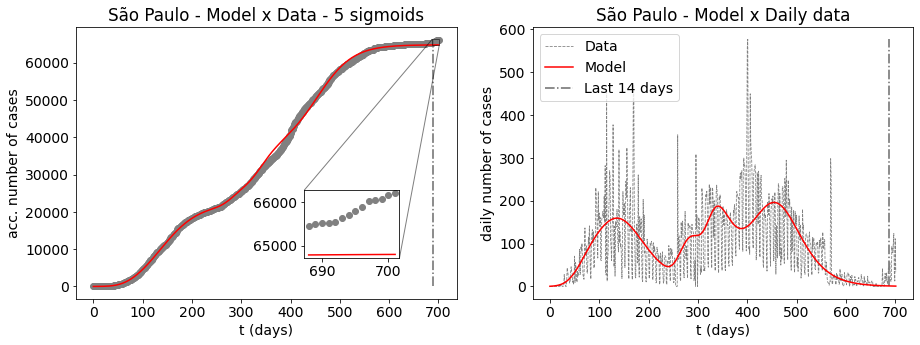

Parameters: [[11883.365347776737, 104.66489331956518, 40.96981758393412, 0.09999999999999999], [10400.676919342488, 156.5886159452999, 40.20444377348169, 0.16658196374460896], [7226.152852127548, 289.7934757019035, 25.956272260908385, 0.09999999999992566], [7979.954798263942, 342.8588217414314, 22.71421494647025, 0.09999999999994148], [27336.9525788928, 455.92636578508854, 35.446154728407954, 1.0]]


<Figure size 432x288 with 0 Axes>

In [12]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

for i in range(len(x_nw)):
    #x_nw[i]
    n_days = x_nw[i] - 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        #A0 = 2*max(y_t)
        A0 = 1*max(y_t) # SP
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 70
        A0 *= 0.005

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    fig, axs = plt.subplots(1, 2, figsize=[15,5])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[0].set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    axs[0].scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    axs[0].vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[0].plot(y_m, label='Model', c='r')
    axs[0].set_xlabel('t (days)')
    axs[0].set_ylabel('acc. number of cases')
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = axs[0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    axs[1].set_title(f'{city_name} - Model x Daily data')
    axs[1].plot(daily_data[:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[1].plot(y_m_daily, label='Model', c='r')
    axs[1].vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[1].set_xlabel('t (days)')
    axs[1].set_ylabel('daily number of cases')
    axs[1].legend(loc=2) # upper left
    plt.savefig(f'ESTADOSP/ACC_DAILY_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'Parameters: {sig_params}\n==================================')    

plt.tight_layout()
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()


In [ ]:
# acc_data

In [ ]:
# # Relative RMSE   (np.sqrt(MSE)/max(acc_data))
# print('Relative RMSE')
# # Mendoza
# print('Buenos Aires: ',round(100*np.sqrt(1485.960)/12562.0, 3),'%')
# print('Rosario: ',round(100*np.sqrt(128.739)/4656.0, 3),'%')
# print('Mendoza: ',round(100*np.sqrt(93.178)/4950.0, 3),'%')

In [ ]:
A_list = []
tp_list = []
delta_list = []
nu_list = []
for i, par_sig_i in zip(range(len(sig_params)), sig_params):
    print(f'Parameters Sigmoid {i}: {par_sig_i}')
    [A, tp, delta, nu] = par_sig_i
    A_list.append(round(A))
    tp_list.append(round(tp))
    delta_list.append(round(delta, 1))
    nu_list.append(round(nu, 3))

data_dict = {
    r'Sigmoid Number':range(len(sig_params)),
    r'A': A_list,
    r'$t_p$': tp_list,
    r'$\nu$': nu_list,
    r'$\delta$': delta_list,
}


In [ ]:
df_params = pd.DataFrame(data_dict)
df_params.to_excel(f'ESTADOSP/Parameters_{city_name}.xlsx')

In [ ]:
df_params

### Predictions - Estado de SP - daily

In [ ]:
# Predictions for the first three waves
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(len(x_nw), 1, figsize=(10,16))
#fig.suptitle(f'{city_name} - Model x Daily number of cases')
fig.suptitle(f'{city_name}')
for i in range(len(x_nw)):
    n_days = x_nw[i] - 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    shift_val = 0

    axs[i].plot(daily_data[shift_val:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i].plot(y_m_daily[shift_val:], label='Model', c='r')
    axs[i].vlines(n_days - 7*n_weeks_pred - shift_val, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i].set_xlabel('t (days)')
    axs[i].set_ylabel('Daily number of cases')
    axs[i].legend(loc=2) # upper left

    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
plt.savefig(f'ESTADOSP/{city_name}_daily', facecolor='white', dpi=100)
plt.show()

### Predictions - Estado de SP - Tudo

========= Wave nr 1 =========
From 0 to  105


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


rRMSE:  0.015005332017777354
rRMSE Predictions:  0.08709779587345458
========= Wave nr 2 =========
From 0 to  154


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


rRMSE:  0.0072138636887329475
rRMSE Predictions:  0.03813473954877433
========= Wave nr 3 =========
From 0 to  476


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


rRMSE:  0.020567786483840906
rRMSE Predictions:  0.059359198497459735
========= Wave nr 4 =========
From 0 to  615


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


rRMSE:  0.014297600972980376
rRMSE Predictions:  0.021024289870496458
========= Wave nr 5 =========
From 0 to  686


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


rRMSE:  0.013186070108816067
rRMSE Predictions:  0.017535629460203015
========= Wave nr 6 =========
From 0 to  746


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


rRMSE:  0.011186874402689666
rRMSE Predictions:  0.06284147238072059


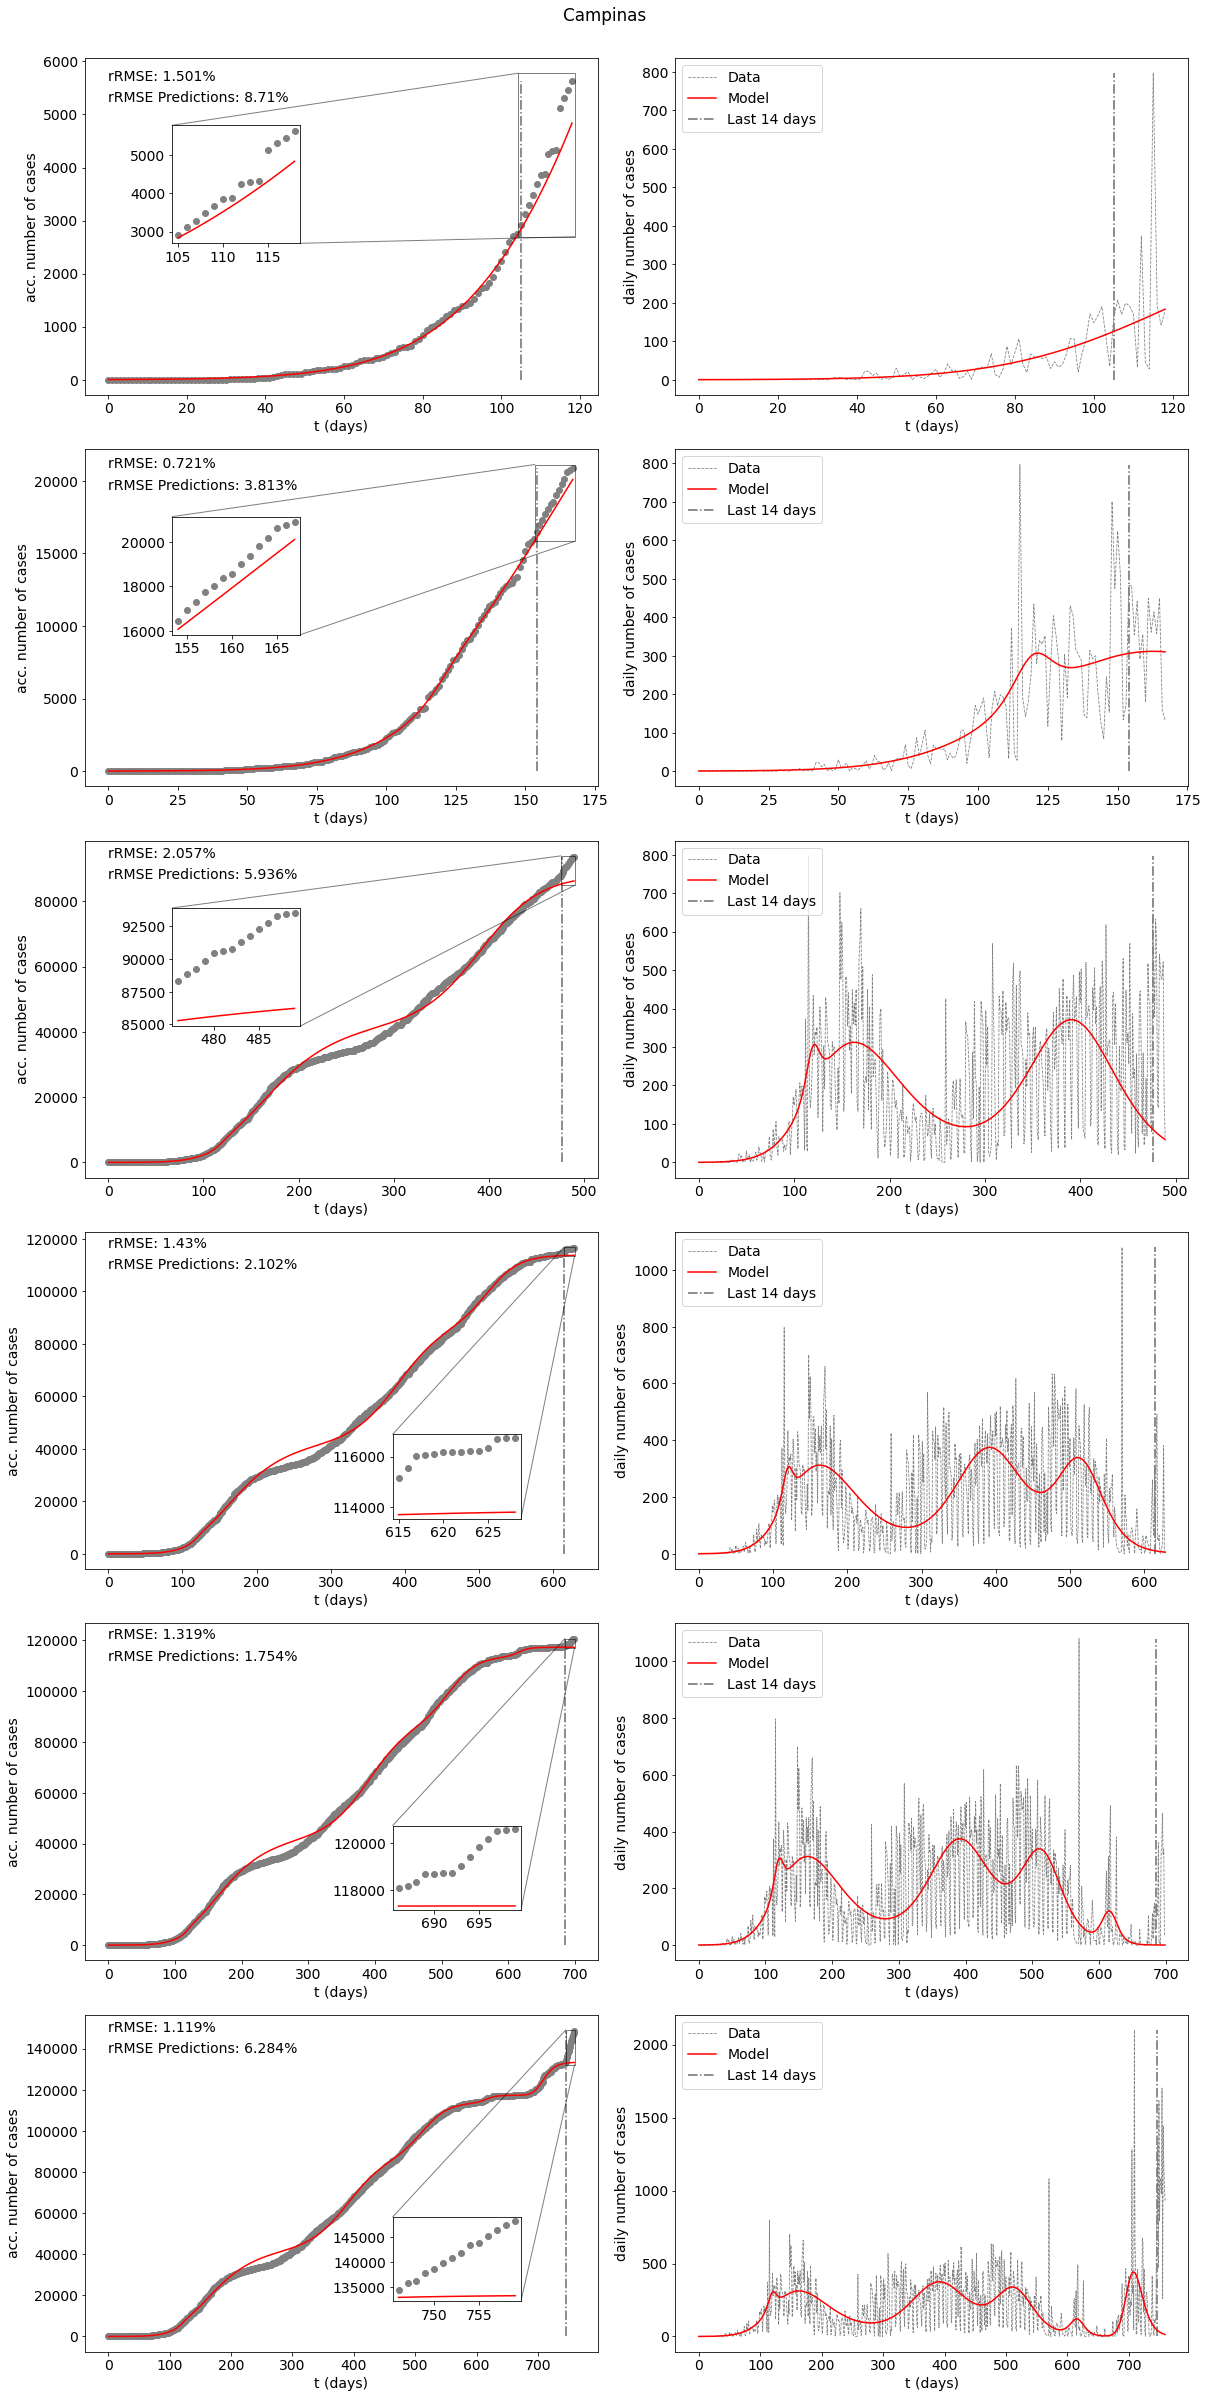

In [32]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(len(x_nw), 2, figsize=(17,34)) #Campinas
#fig, axs = plt.subplots(len(x_nw), 2, figsize=(12,18)) #SJC
#fig, axs = plt.subplots(len(x_nw), 2, figsize=(13,20)) #SP #SJC
fig.suptitle(f'{city_name}')

for i in range(len(x_nw)):
    #x_nw[i]
    n_days = x_nw[i] - 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    #print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        #A0 = 1*max(y_t) # SP
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 70 
        A0 *= 0.005

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    #print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    #print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    
    # Relative RMSE   (np.sqrt(MSE)/max(acc_data))
    rel_rmse = np.sqrt(sol.fun) / max(acc_data[:n_days])
    print('rRMSE: ', rel_rmse)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    #fig, axs = plt.subplots(1, 2, figsize=[15,5])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[i][0].scatter(t[:n_days], scaling_factor *acc_data[:n_days], label='Data', c='gray')
    axs[i][0].vlines(n_days - 7*n_weeks_pred, 0, scaling_factor * max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i][0].plot(scaling_factor * y_m, label='Model', c='r')
    axs[i][0].set_xlabel('t (days)')
    axs[i][0].set_ylabel('acc. number of cases')
    
    axs[i][0].text(0, scaling_factor * max(y_t), f'rRMSE: {round(100*rel_rmse, 3)}%')

    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]

    # Relative RMSE for the predictions
    y_t_pred = acc_data[n_days - 7*n_weeks_pred:n_days]
    y_m_pred = Y_detail
    mse_pred = (1/len(y_t_pred))*np.sum((y_t_pred - y_m_pred)**2)
    rel_rmse_pred = np.sqrt(mse_pred) / max(acc_data[:n_days])

    print('rRMSE Predictions: ', rel_rmse_pred)

    axs[i][0].text(0, scaling_factor *0.93*max(y_t), f'rRMSE Predictions: {round(100*rel_rmse_pred, 3)}%')

    # detail prediction
    if(n_sig < 4):
        sub_axes = axs[i][0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[i][0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], scaling_factor *acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, scaling_factor *Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[i][0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    #axs[i][1].set_title(f'{city_name} - Model x Daily data')
    axs[i][1].plot(scaling_factor * np.array(daily_data[:n_days]), label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i][1].plot(scaling_factor * np.array(y_m_daily), label='Model', c='r')
    axs[i][1].vlines(n_days - 7*n_weeks_pred, 0, scaling_factor * max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i][1].set_xlabel('t (days)')
    axs[i][1].set_ylabel('daily number of cases')
    axs[i][1].legend(loc=2) # upper left    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    #print(f'Parameters: {sig_params}\n==================================')    

plt.tight_layout(rect=[0, 0, 1, 0.98])
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.savefig(f'ESTADOSP/{city_name}', facecolor='white', dpi=200)
plt.show()




<AxesSubplot:>

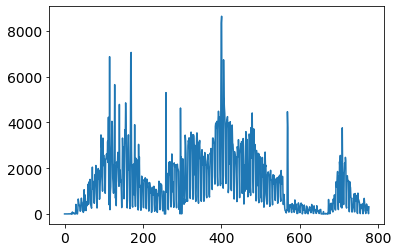

In [13]:
data.new_confirmed.plot()